In [ ]:
import GEOparse
import pandas as pd

# Load GSE197406
gse = GEOparse.get_GEO(geo="GSE197406", destdir="../GEO")

# Expression matrix: probes x samples
expr_matrix = gse.pivot_samples("VALUE")

# Phenotype / metadata
pheno = gse.phenotype_data

# Quick check
print(expr_matrix.shape)
print(pheno.head())


In [ ]:
import numpy as np

# Check the relevant phenotype column
print(pheno.columns)
print(pheno["source_name_ch1"].unique())



# Define condition labels based on text in 'source_name_ch1'
pheno["condition"] = np.where(
    pheno["source_name_ch1"].str.contains("no liver abnormality", case=False),
    "control",
    "cirrhosis"
)

# Confirm the distribution
print(pheno["condition"].value_counts())

# Optional: make sure sample order matches expression matrix columns
pheno = pheno.loc[expr_matrix.columns]


In [5]:
import GEOparse

# Download platform annotation (Affymetrix Human Genome U133 Plus 2.0 Array)
gpl = GEOparse.get_GEO("GPL570", destdir="../GEO")

# Extract mapping: Probe ID → Gene Symbol
gpl_table = gpl.table[["ID", "Gene Symbol"]].copy()
gpl_table.columns = ["probe_id", "gene_symbol"]

print(gpl_table.head())


09-Oct-2025 18:10:59 DEBUG utils - Directory ../GEO already exists. Skipping.
09-Oct-2025 18:10:59 INFO GEOparse - File already exist: using local version.
09-Oct-2025 18:10:59 INFO GEOparse - Parsing ../GEO/GPL570.txt: 
09-Oct-2025 18:10:59 DEBUG GEOparse - PLATFORM: GPL570


    probe_id       gene_symbol
0  1007_s_at  DDR1 /// MIR4640
1    1053_at              RFC2
2     117_at             HSPA6
3     121_at              PAX8
4  1255_g_at            GUCA1A


/Volumes/NGS/conda/miniconda3/envs/akms/lib/python3.11/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


In [40]:
# Merge by probe_id (expression index)
expr_annot = expr_matrix.merge(
    gpl_table,
    left_index=True,
    right_on="probe_id"
)

# Remove duplicates and set gene symbol as new index
expr_annot = expr_annot.drop_duplicates(subset="gene_symbol").set_index("gene_symbol")

print(expr_annot.shape)
print(expr_annot.head())


(23521, 16)
                  GSM5916425  GSM5916426  GSM5916427  GSM5916428  GSM5916429  \
gene_symbol                                                                    
DDR1 /// MIR4640     8.25153     7.76315     8.40313     7.98926     8.05217   
RFC2                 6.74268     6.75010     6.50660     6.88312     6.97066   
HSPA6                6.74961     6.53426     6.72746     6.90891     6.80198   
PAX8                 8.79223     8.73107     9.32590     9.22579     9.28703   
GUCA1A               5.60172     5.69342     5.70023     5.77163     5.73856   

                  GSM5916430  GSM5916431  GSM5916432  GSM5916433  GSM5916434  \
gene_symbol                                                                    
DDR1 /// MIR4640     8.44563     7.58667     8.02614     9.79436     9.66555   
RFC2                 6.76910     6.89180     6.67075     6.93478     6.90036   
HSPA6                6.80546     6.76402     6.76341     6.74732     6.86814   
PAX8                 9.4274

In [41]:
expr_annot.columns

Index(['GSM5916425', 'GSM5916426', 'GSM5916427', 'GSM5916428', 'GSM5916429',
       'GSM5916430', 'GSM5916431', 'GSM5916432', 'GSM5916433', 'GSM5916434',
       'GSM5916435', 'GSM5916436', 'GSM5916437', 'GSM5916438', 'GSM5916439',
       'probe_id'],
      dtype='object')

In [43]:

# Step 1: Move 'probe_id' to index if it exists
if 'probe_id' in expr_annot.columns:
    exprs_matrix_clean = expr_annot.set_index('probe_id')
else:
    exprs_matrix_clean = expr_annot.copy()

# Step 2: Ensure all values are numeric
expr_matrix_clean = exprs_matrix_clean.apply(pd.to_numeric, errors='coerce')

# Step 3: Keep only columns that are actual samples in pheno
common_samples = expr_matrix_clean.columns.intersection(pheno.index)
expr_matrix_clean = expr_matrix_clean[common_samples]
pheno = pheno.loc[common_samples]

# Step 4: Reorder columns of expression to match pheno
expr_matrix_clean = expr_matrix_clean[pheno.index]

# Step 5: Verify
print("Expression shape:", expr_matrix_clean.shape)
print("Pheno shape:", pheno.shape)
print("Column names match pheno index?:", (expr_matrix_clean.columns == pheno.index).all())

Expression shape: (23521, 15)
Pheno shape: (15, 38)
Column names match pheno index?: True


In [49]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()


# Send cleaned data to R
ro.globalenv["exprs_data"] = pandas2ri.py2rpy(exprs_matrix_clean)
ro.globalenv["pheno_data"] = pandas2ri.py2rpy(pheno)

# R code for limma
r_code = """
library(limma)

# Ensure expression is numeric matrix
exprs_data <- as.matrix(exprs_data)

# Ensure rownames of pheno match column names of expression
rownames(pheno_data) <- colnames(exprs_data)

# Make sure condition is a factor
pheno_data$condition <- factor(pheno_data$condition)

# Design matrix
design <- model.matrix(~0 + condition, data=pheno_data)
colnames(design) <- levels(pheno_data$condition)

# Fit linear model
fit <- lmFit(exprs_data, design)

# Define contrasts (cirrhosis vs control)
contrast.matrix <- makeContrasts(cirrhosis - control, levels=design)

fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)

# Get DEGs
deg_table <- topTable(fit2, adjust.method="BH", number=Inf)
"""

# Run R code and automatically convert to pandas DataFrame
deg_results = ro.r(r_code)

print(type(deg_results))  # should be <class 'pandas.core.frame.DataFrame'>
print(deg_results.head())



<class 'pandas.core.frame.DataFrame'>
                logFC    AveExpr          t       P.Value     adj.P.Val  \
206606_at   -3.327967  10.301449 -21.843074  8.066237e-13  1.897260e-08   
215712_s_at -1.966677   8.213155 -17.843912  1.524184e-11  1.792517e-07   
1559573_at  -3.936164   8.351419 -16.861771  3.441795e-11  2.698482e-07   
209978_s_at -2.243936  13.369680 -16.346414  5.369708e-11  2.705321e-07   
220801_s_at -4.145404   9.658891 -16.268232  5.750863e-11  2.705321e-07   

                     B  
206606_at    18.703118  
215712_s_at  16.315775  
1559573_at   15.617827  
209978_s_at  15.230788  
220801_s_at  15.170756  


In [50]:
deg_results["Regulation"] = "NotSig"
deg_results.loc[(deg_results["adj.P.Val"] < 0.05) & (deg_results["logFC"] > 0.6), "Regulation"] = "Up"
deg_results.loc[(deg_results["adj.P.Val"] < 0.05) & (deg_results["logFC"] < -0.6), "Regulation"] = "Down"


In [51]:
deg_results

,logFC,AveExpr,t,P.Value,adj.P.Val,B,Regulation
206606_at,-3.327967e+00,10.301449,-21.843074,8.066237e-13,1.897260e-08,18.703118,Down
215712_s_at,-1.966677e+00,8.213155,-17.843912,1.524184e-11,1.792517e-07,16.315775,Down
1559573_at,-3.936164e+00,8.351419,-16.861771,3.441795e-11,2.698482e-07,15.617827,Down
209978_s_at,-2.243936e+00,13.369680,-16.346414,5.369708e-11,2.705321e-07,15.230788,Down
220801_s_at,-4.145404e+00,9.658891,-16.268232,5.750863e-11,2.705321e-07,15.170756,Down
...,...,...,...,...,...,...,...
224500_s_at,-3.017857e-05,7.482715,-0.000602,9.995278e-01,9.996978e-01,-6.834344,NotSig
217815_at,8.642857e-05,8.121785,0.000488,9.996168e-01,9.997217e-01,-6.834344,NotSig
1560958_s_at,4.267857e-05,6.371819,0.000463,9.996367e-01,9.997217e-01,-6.834344,NotSig
209881_s_at,-2.428571e-05,7.094269,-0.000359,9.997186e-01,9.997611e-01,-6.834344,NotSig


In [55]:
deg_results["Regulation"].value_counts()

Regulation
NotSig    22115
Down        765
Up          641
Name: count, dtype: int64

In [57]:

deg_results = deg_results.reset_index().rename(columns={"index": "probe_id"})


In [58]:
deg_annotated = deg_results.merge(gpl_table, 
                                  on="probe_id", 
                                  how="left")
deg_annotated


,probe_id,logFC,AveExpr,t,P.Value,adj.P.Val,B,Regulation,gene_symbol
0,206606_at,-3.327967e+00,10.301449,-21.843074,8.066237e-13,1.897260e-08,18.703118,Down,LIPC
1,215712_s_at,-1.966677e+00,8.213155,-17.843912,1.524184e-11,1.792517e-07,16.315775,Down,IGFALS
2,1559573_at,-3.936164e+00,8.351419,-16.861771,3.441795e-11,2.698482e-07,15.617827,Down,LINC01093
3,209978_s_at,-2.243936e+00,13.369680,-16.346414,5.369708e-11,2.705321e-07,15.230788,Down,LPA /// PLG
4,220801_s_at,-4.145404e+00,9.658891,-16.268232,5.750863e-11,2.705321e-07,15.170756,Down,HAO2
...,...,...,...,...,...,...,...,...,...
23516,224500_s_at,-3.017857e-05,7.482715,-0.000602,9.995278e-01,9.996978e-01,-6.834344,NotSig,MON1A
23517,217815_at,8.642857e-05,8.121785,0.000488,9.996168e-01,9.997217e-01,-6.834344,NotSig,SUPT16H
23518,1560958_s_at,4.267857e-05,6.371819,0.000463,9.996367e-01,9.997217e-01,-6.834344,NotSig,LOC101928516
23519,209881_s_at,-2.428571e-05,7.094269,-0.000359,9.997186e-01,9.997611e-01,-6.834344,NotSig,LAT


###### Volcano plot ####

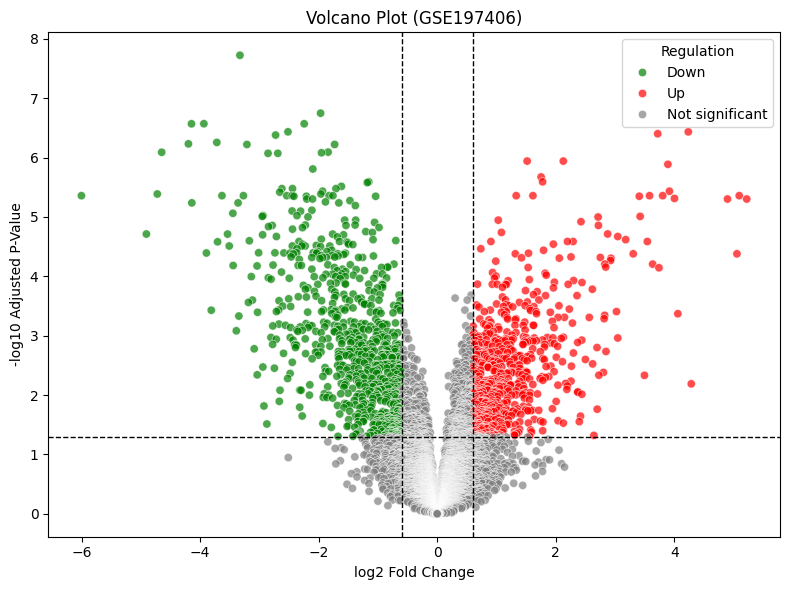

Significance
Not significant    22115
Down                 765
Up                   641
Name: count, dtype: int64


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Thresholds
logFC_up = 0.6
logFC_down = -0.6
pval_cutoff = 0.05

# Categorize DEGs
deg_annotated['Significance'] = 'Not significant'
deg_annotated.loc[(deg_annotated['logFC'] > logFC_up) & (deg_annotated['adj.P.Val'] < pval_cutoff), 'Significance'] = 'Up'
deg_annotated.loc[(deg_annotated['logFC'] < logFC_down) & (deg_annotated['adj.P.Val'] < pval_cutoff), 'Significance'] = 'Down'

# Volcano plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=deg_annotated,
    x='logFC',
    y=-np.log10(deg_annotated['adj.P.Val']),
    hue='Significance',
    palette={'Up': 'red', 'Down': 'green', 'Not significant': 'grey'},
    alpha=0.7
)

# Threshold lines
plt.axhline(-np.log10(pval_cutoff), color='black', linestyle='--', linewidth=1)
plt.axvline(logFC_up, color='black', linestyle='--', linewidth=1)
plt.axvline(logFC_down, color='black', linestyle='--', linewidth=1)

plt.title("Volcano Plot (GSE197406)")
plt.xlabel("log2 Fold Change")
plt.ylabel("-log10 Adjusted P-Value")
plt.legend(title='Regulation')
plt.tight_layout()
plt.show()

# Count summary
print(deg_annotated['Significance'].value_counts())


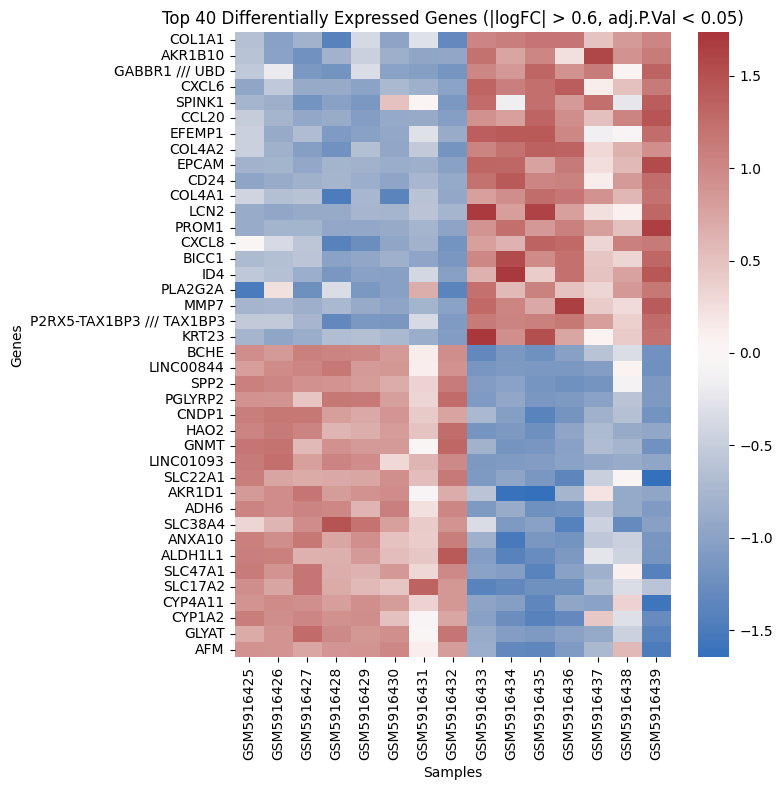

In [68]:
# Select top 20 up and 20 down genes
top_up = deg_annotated.query("Significance == 'Up'").nlargest(20, 'logFC')
top_down = deg_annotated.query("Significance == 'Down'").nsmallest(20, 'logFC')

top_genes = pd.concat([top_up, top_down])
top_probes = top_genes['probe_id']

# Extract expression values
expr_top = expr_matrix.loc[top_probes]

# Replace probe IDs with gene symbols for clarity
expr_top.index = top_genes.set_index('probe_id').loc[expr_top.index, 'gene_symbol']

# Z-score normalization across samples (for visual scaling)
expr_scaled = (expr_top - expr_top.mean(axis=1).values.reshape(-1,1)) / expr_top.std(axis=1).values.reshape(-1,1)

# Heatmap
plt.figure(figsize=(8,8))
sns.heatmap(expr_scaled, cmap='vlag', center=0, yticklabels=True)
plt.title("Top 40 Differentially Expressed Genes (|logFC| > 0.6, adj.P.Val < 0.05)")
plt.xlabel("Samples")
plt.ylabel("Genes")
plt.tight_layout()
plt.show()
